### Based on soss_engine.ipynb

### Imports

In [8]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Import standard packages.
import numpy as np
from astropy.io import fits
from scipy.interpolate import UnivariateSpline

# Imports from the extraction.
from dms.soss_engine import ExtractionEngine
from extract.engine_legacy import ThroughputSOSS, WebbKer
from dms.engine_utils import grid_from_map, get_soss_grid

# Imports for plots.
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Matplotlib defaults

In [9]:
%matplotlib inline

In [10]:
plt.rc('figure', figsize=(13,8)) 
plt.rc('font', size=16)
plt.rc('image', cmap='inferno')
plt.rc('lines', lw=2)

In [14]:
WORKING_DIR = '/home/kmorel/ongenesis/jwst-user-soss/PHY3030/'

In [15]:
gain = 1.61   #[é]

def no_dms_simulation(file_name, gain=gain):
    with fits.open(WORKING_DIR + file_name) as hdulist:
        ng = hdulist[0].header['NGROUPS']      #n_groups
        t_read = hdulist[0].header['TGROUP']   # Reading time [s]
        tint = (ng - 1) * t_read               # Integration time [s]
        
        simu = hdulist
        data = (hdulist[1].data[:,-1] - hdulist[1].data[:,0]) / tint / gain   # Images of flux [adu/s]
    return simu, data

def rateints_dms_simulation(file_name):
    with fits.open(WORKING_DIR + file_name) as hdulist:
        data_noisy_rateints = hdulist[1].data     # Images of flux [adu/s]
        #delta_noisy = hdulist[2].data            # Errors [adu/s]
        dq = hdulist[3].data                      # Data quality
        i = np.where(dq % 2 != 0)  # Odd values of dq = DO NOT USE these pixels
        data_noisy_rateints[i[0], i[1], i[2]] = 0.
        #delta_noisy[i[0], i[1], i[2]] = 0.
        
        simu = hdulist
        data = data_noisy_rateints
    return simu, data, i

## Read some ref files

In [16]:
# List of orders to consider in the extraction.
soss_orders = [1, 2]

#### Wavelength solution ####  # WaveMap TODO try using DataModels.
wave_maps = []
wave_maps.append(fits.getdata("/genesis/jwst/userland-soss/loic_review/cartewaveGJT.fits"))
wave_maps.append(fits.getdata("/genesis/jwst/userland-soss/loic_review/cartewaveGJT_order2.fits"))
wave_maps[1] = np.where(np.isnan(wave_maps[1]), np.nanmin(wave_maps[1]), wave_maps[1])

#### Spatial profiles ####
spat_pros = fits.getdata("/genesis/jwst/userland-soss/loic_review/2DTrace_native_nopadding_20210729.fits")
spat_pros = spat_pros[:2]

# Convert data from fits files to float (fits precision is 1e-8)
wave_maps = [wv.astype('float64') for wv in wave_maps]
spat_pros = [p_ord.astype('float64') for p_ord in spat_pros]

# SpecTrace
thrpt_list = [ThroughputSOSS(order) for order in soss_orders]

# SpecKernel
ker_list = [WebbKer(wv_map) for wv_map in wave_maps]

# Put all inputs from reference files in a list
ref_files = [wave_maps, spat_pros, thrpt_list, ker_list]

## Load simulation

In [17]:
# CHOOSE simulations to use/compare: CHANGE True's and False's
# CHANGE 1 and 2 values for data variable also!!!  
if False:   # Photon noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon_rateints.fits')
    simulation_0 = 'Photon noise, after DMS'
    
if False:   # Superbias noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--superbias_rateints.fits')
    simulation_0 = 'Superbias noise, after DMS'
    
if False:   # Nonlinearity noise, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--nonlinearity_rateints.fits')
    simulation_0 = 'Nonlinearity noise, after DMS'
    
if True:   # Photon, superbias and nonlinearity noises, after DMS
    simu_2, data_2, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon--nonlinearity--superbias_rateints.fits')
    simulation_2 = 'Photon, nonlinearity and superbias noises, after DMS'
    
if False:   # Photon and superbias noises, after DMS
    simu_0, data_0, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noisy--photon--superbias_rateints.fits')
    simulation_0 = 'Photon and superbias noises, after DMS'

if False:   # Noiseless, no DMS
    simu_0, data_0 = no_dms_simulation('IDTSOSS_clear.fits')
    simulation_0 = 'Noiseless, no DMS' 
    #data_0[bad_ind[0], bad_ind[1], bad_ind[2]] = 0. # I put bad pixels to 0 here too
    
if True:   # Noiseless, after DMS
    simu_1, data_1, bad_ind = rateints_dms_simulation('IDTSOSS_clear_noNoise_rateints.fits')
    simulation_1 = 'Noiseless, after DMS'
    
# Convert data from fits files to float (fits precision is 1e-8)
data_1 = data_1.astype('float64', copy=False)
data_2 = data_2.astype('float64', copy=False)
#delta_noisy = delta_noisy.astype('float64', copy=False)

print('Simulation 1:', simulation_1)
print('Simulation 2:', simulation_2)

Simulation 1: Noiseless, after DMS
Simulation 2: Photon, nonlinearity and superbias noises, after DMS


In [18]:
# The science array
scidata = data_2[0]       ###########TO CHECK

# Build an associated error array
bkgd_noise = 20.  # In counts?
scierr = np.sqrt(scidata + bkgd_noise**2)         ################ TO KEEP?

## Extraction

### NEW STEP: First pass to estimate the extracted flux
Used to initialize the tikhonov factor

In [19]:
# Oversampling of 1 to make sure the solution will be stable
n_os = 1

# Define wavelength grid based on order 1 only
wave_grid = grid_from_map(wave_maps[0], spat_pros[0], n_os=n_os)

# Save boundaries for later
wave_bounds = [np.min(wave_grid), np.max(wave_grid)]

# Mask parts contaminated by order 2
mask = (spat_pros[1] >= 1e-4)

# Init extraction without convolution kernel (so extract the spectrum at order 1 resolution)
extract = ExtractionEngine([wave_maps[0]], [spat_pros[0]], [ThroughputSOSS(1)] , [np.array([1.])],
             wave_grid=wave_grid, orders=[1], global_mask=mask)

# Extract estimate
spec_estimate = extract(data=scidata, error=scierr)

# Interpolate
idx = np.isfinite(spec_estimate)
estimate = UnivariateSpline(wave_grid[idx], spec_estimate[idx], k=3, s=0, ext=0)

### Extraction Parameters
(Example usage with few inputs parameters.)

In [20]:
params = {}

# Wavelength extraction grid oversampling
params["n_os"] = 5

# Threshold on the spatial profile
# Only pixels above this threshold will be used for extraction (for at least one order)
params["threshold"] = 1e-4   # Same units as the spatial profiles

# Explicitly specify the wavelength grid
# Only extract wavelength covered by order 1 since
# the blue end of order 2 doesn't help the decontamination
[wv_min, wv_max] = wave_bounds
wave_grid = get_soss_grid(wave_maps, spat_pros, n_os=params["n_os"], wave_min=wv_min, wave_max=wv_max)
params["wave_grid"] = wave_grid

### Initiate extraction object
(This needs to be done only once unless the oversampling (`n_os`) changes.)

In [21]:
extract = ExtractionEngine(*ref_files, **params)

## NEW STEP: Set tikhonov matrix

In [23]:
# Parameters to build tikhonov matrix
tikho_params = dict()
tikho_params['pwr_law'] = 0
tikho_params['estimate'] = estimate

# Init the tikhonov matrix
extract.set_tikho_matrix(fkwargs=tikho_params)

### Find the best tikhonov factor
This takes some time, so it's better to do it once if the exposures are part of a time series observation, i.e. observations of the same object at similar SNR.

In [24]:
# Get an estimate of the factor grid
factors = extract.estimate_tikho_factors(estimate, log_range=[-4, 4], n_points=10)

# First search for best factor
tikho_tests = extract.get_tikho_tests(factors, data=scidata, error=scierr)

Testing factors...
10/10


0.0002546552137665898


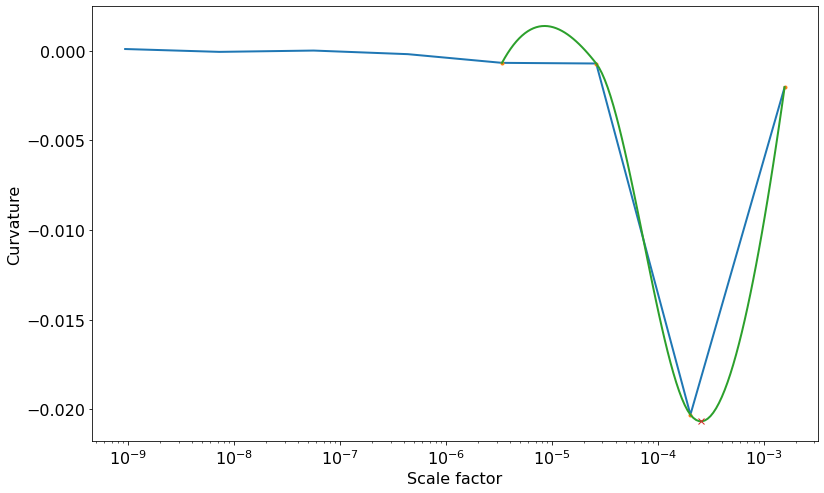

In [25]:
# Get best factor using the corner of the l-plot
best_fac = tikho_tests.best_tikho_factor(i_plot=True, mode='curvature')
print(best_fac)

In [26]:
# Refine the grid (span 4 orders of magnitude).
best_fac = np.log10(best_fac)
factors = np.logspace(best_fac-2, best_fac+2, 20)

# Test these new factors.
tests_zoomed = extract.get_tikho_tests(factors, data=scidata, error=scierr)

Testing factors...
20/20


0.00024033564471316008


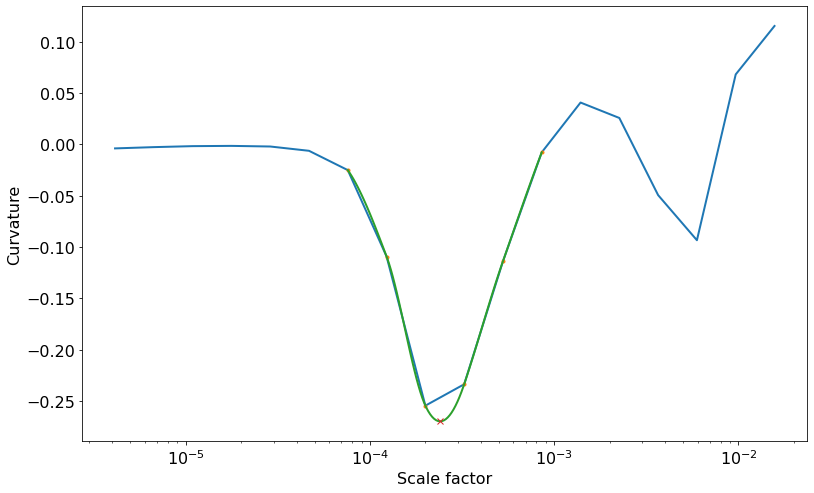

In [27]:
# Find the best factor.
best_fac = tests_zoomed.best_tikho_factor(i_plot=True, mode='curvature')
print(best_fac)

(None,
 <AxesSubplot:xlabel='$\\left(||\\mathbf{Ax-b}||^2_2\\right)$', ylabel='$\\left(||\\mathbf{\\Gamma.x}||^2_2\\right)$'>)

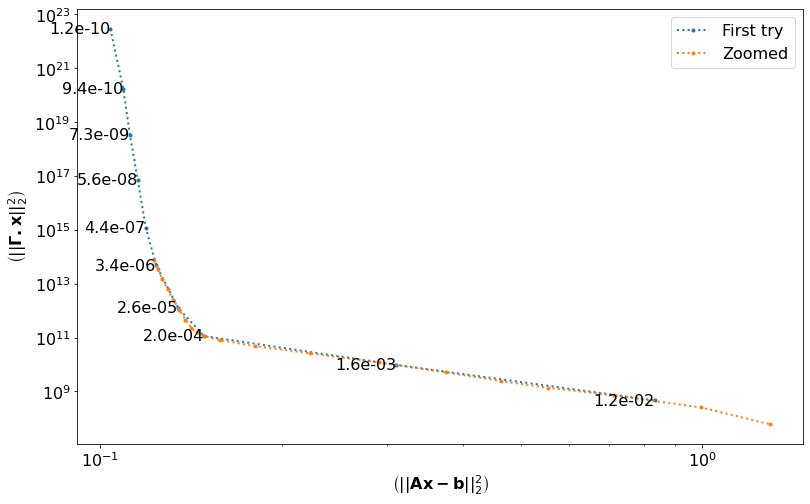

In [28]:
fig, ax = tikho_tests.l_plot(label='First try')
tests_zoomed.l_plot(ax=ax, label='Zoomed', text_label=False)

### Extract the oversampled spectrum $f_k$
Can be done in a loop for a timeseries and/or iteratively for different estimates of the reference files.

In [29]:
wave_bin_array = np.zeros(shape=(np.shape(data_2)[0], np.shape(data_2)[2]), dtype='float')
flux_bin_array = np.zeros(shape=(np.shape(data_2)[0], np.shape(data_2)[2]), dtype='float')

for t in range(np.shape(data_2)[0]):  # For each image of the timeseries
    scidata = data_2[t]
    
    # Extract the spectrum.
    f_k = extract.extract(data=scidata, error=scierr, tikhonov=True, factor=best_fac)
    
    if False:
        # Plot the extracted spectrum.
        plt.plot(extract.wave_grid, f_k)
        plt.xlabel("Wavelength [$\mu m$]")
        plt.ylabel("Oversampled Spectrum $f_k$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")
        # For now, arbitrairy units, but it should be the flux that hits the detector,
        # so energy/time/wavelength
        plt.tight_layout()
        plt.show()
    
    ### Bin to pixel native sampling
    # To get a result comparable to typical extraction methods, we need to integrate the oversampled 
    # spectrum ($f_k$) to a grid representative of the native pixel sampling (for each order). 
    # This integration is done according to the equation
    # \begin{equation}
    # \mathrm{bin}_{i} = \int_{\lambda_{ni}^-}^{\lambda_{ni}^+} T_n(\lambda)\tilde{f}_n(\lambda)\lambda d\lambda \, ,
    # \end{equation}
    # where $n$ is a given order, $T_n$ is the throughput of the order and $\tilde{f}_n$ is the 
    # underlying flux convolved to the order $n$ resolution. The result of this integral will be in 
    # fake counts (it is not directly the sum of the counts so that's why I call it fake). 
    # One could directly extract the integrated flux by setting the throughput to $T_n(\lambda) = 1$ 
    # (see second example). The result would then be in flux units instead of counts.
    
    #### Bin in counts
    
    # Save the output in a list for different orders.
    flux_bin = []  # Integrated flux
    wave_bin = []  # Wavelength grid

    for i_ord in range(extract.n_orders):

        # Integrate
        wave_bin_, flux_bin_ = extract.bin_to_pixel(spectrum=f_k, i_order=i_ord)

        # Save
        wave_bin.append(wave_bin_)
        flux_bin.append(flux_bin_)
    
    if False:
        fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,6))

        for i_ord in range(extract.n_orders):

            label = extract.orders[i_ord]
            ax[i_ord].plot(wave_bin[i_ord], flux_bin[i_ord], label=label)

        ax[0].set_ylabel("Extracted signal [counts]")

        ax[1].set_xlabel("Wavelength [$\mu m$]")
        ax[1].set_ylabel("Extracted signal [counts]")

        plt.tight_layout()
        plt.show()
    
    if False:
        # Bin in flux units
        
        # Set throughput to 1
        def throughput(x):
            return np.ones_like(x)

        flux_bin = []  # Integrated flux
        wave_bin = []  # Wavelength grid

        for i_ord in range(extract.n_orders):

            # Integrate.
            wave_bin_, flux_bin_ = extract.bin_to_pixel(spectrum=f_k, i_order=i_ord, throughput=throughput)

            # Save.
            wave_bin.append(wave_bin_)
            flux_bin.append(flux_bin_)
            
            # Plot
            label = extract.orders[i_ord]
            plt.plot(wave_bin[i_ord], flux_bin[i_ord], label=label)
    
        plt.ylabel(r"Convolved flux $\tilde{f_k}$ [energy$\cdot s^{-1} \cdot \mu m^{-1}$]")  
        plt.xlabel("Wavelength [$\mu m$]")

        plt.tight_layout()
        plt.legend(title="Order")
        plt.show()
        
    wave_bin_array[t] = wave_bin[0]  # Only save order 1
    flux_bin_array[t] = flux_bin[0]

    print('\r...t = {}: Done'.format(t), end='', flush=True)

...t = 439: Done

## Quality estimate

### Rebuild the detector

In [30]:
model_image = extract.rebuild(f_k)

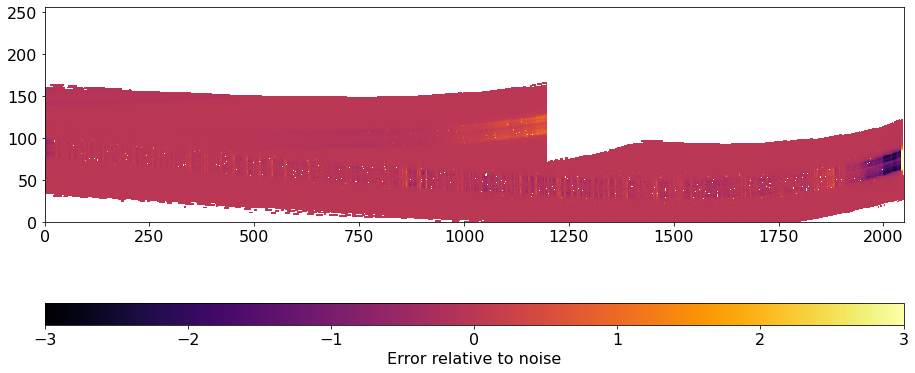

In [31]:
plt.subplot(111, aspect=2)

plt.pcolormesh((model_image - scidata)/scierr, vmin=-3, vmax=3)

plt.colorbar(label="Error relative to noise", orientation='horizontal', aspect=40)

plt.tight_layout()
plt.show()